In [1]:
import json
import pickle
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import timm
import torch
from custom_transforms import RandomCirclePut, RandomTextPut
from datasets import MyDataset
from PIL import Image, ImageDraw, ImageFont
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import ConcatDataset, DataLoader
from torchvision import models, transforms
from tqdm import tqdm

/home/fromy/anaconda3/envs/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [3]:
df = pd.read_csv('../data/images.csv')
df.head()

,name,isTemplate,exampleId,exampleText,filename,url
0,drake hotline bling,True,NaN,NaN,drake hotline bling.jpg,https://imgflip.com/s/meme/Drake-Hotline-Bling...
1,drake hotline bling,False,0.0,My brain at 3 am | Nobody:; My brain at 3 am:...,drake hotline bling_0.jpg,https://i.imgflip.com/796lki.jpg
2,drake hotline bling,False,1.0,Drake Hotline Bling | imgflip views; imgflip ...,drake hotline bling_1.jpg,https://i.imgflip.com/796rcj.jpg
3,drake hotline bling,False,2.0,Drake Hotline Bling | Don't trust in autosave...,drake hotline bling_2.jpg,https://i.imgflip.com/796vlh.jpg
4,drake hotline bling,False,3.0,Drake Hotline Bling | Coins you find in your ...,drake hotline bling_3.jpg,https://i.imgflip.com/7992fu.jpg


In [4]:
label_converter = json.load(open('../data/image_templates.json', 'r'))
label_converter = {v: int(k) for k, v in label_converter.items()}

In [5]:
df['label'] = df['name'].apply(lambda x: label_converter[x])

In [6]:
df['path'] = '../data/resized_images/' + df['filename']

In [7]:
train_df = df.query('isTemplate')
test_df = df.query('~isTemplate')

In [8]:
train_transforms = transforms.Compose(
    [
        # transforms.Resize((224, 224)),
        RandomTextPut(),
        RandomCirclePut(),
        transforms.RandomRotation((-25, 25)),
        transforms.RandomPerspective(0.2, 0.5),
        transforms.RandomResizedCrop((224, 224), scale=(0.8, 1)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
test_transforms = transforms.Compose(
    [
        # transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

In [9]:
train_dataset = ConcatDataset(
    [MyDataset(train_df, "train", train_transforms, "path", "label") for _ in range(15)]
)
val_dataset = MyDataset(test_df, "val", test_transforms, "path", "label")


In [10]:
train = DataLoader(train_dataset, batch_size=128, shuffle=True)
val = DataLoader(val_dataset, batch_size=128, shuffle=True)
dataloaders = {"train": train, "val": val}

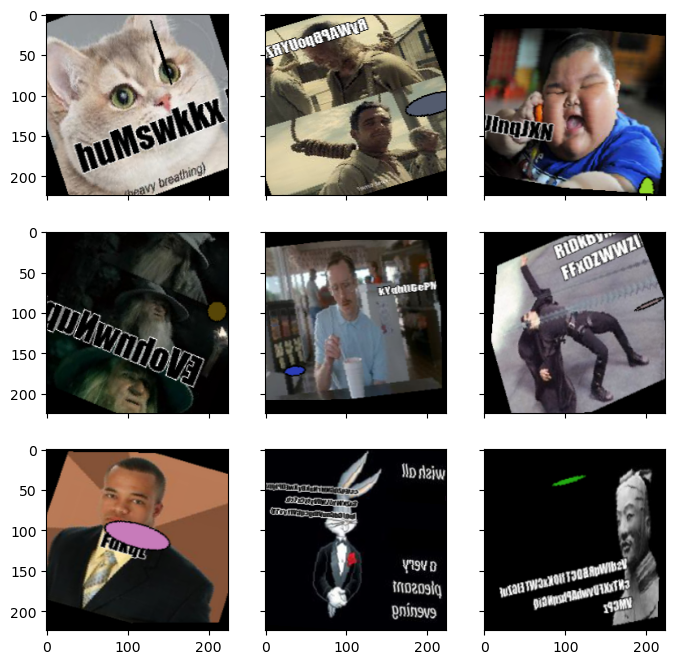

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 950))
    im_val, label = train_dataset[random_characters]
    imshow(im_val.data.cpu(), plt_ax=fig_x)

In [14]:
model = timm.create_model(
    "vit_small_patch32_224_in21k", pretrained=True, num_classes=train_df.name.nunique()
).to("cuda")


In [15]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-4, weight_decay=5e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [16]:
num_epochs = 10
load_best_weights = True

In [17]:
losses = {'train': [], 'val': []}
best_accuracy = 0.0
for epoch in range(num_epochs):
    tqdm.write(f"Epoch {epoch:03d}")
    for phase in ["train", "val"]:
        if phase == "train":
            model.train()
        else:
            model.eval()

        running_loss = 0
        running_corrects = 0

        for x_batch, y_batch in tqdm(dataloaders[phase], desc=f"Phase {phase}"):
            x_batch = x_batch.cuda()
            y_batch = y_batch.cuda()

            if phase == "train":
                optimizer.zero_grad()
                outputs = model(x_batch)
            else:
                with torch.no_grad():
                    outputs = model(x_batch)
            preds = torch.argmax(outputs, -1)
            loss_value = loss(outputs, y_batch)

            if phase == "train":
                loss_value.backward()
                optimizer.step()

            running_loss += loss_value.item()
            running_corrects += int(torch.sum(preds == y_batch.data)) / len(
                y_batch
            )

        epoch_loss = running_loss / len(dataloaders[phase])
        epoch_acc = running_corrects / len(dataloaders[phase])

        losses[phase].append(epoch_loss)

        if phase == "val" and epoch_acc > best_accuracy:
            best_accuracy = epoch_acc
            best_weights = model.state_dict()

        tqdm.write(f"\tLoss: {epoch_loss:0.5f}, Accuracy {epoch_acc:0.5f}")
    if scheduler:
        scheduler.step()
    print("-" * 40)
    
if load_best_weights:
    model.load_state_dict(best_weights)

print(f"Best val Acc: {best_accuracy:4f}")


Epoch 000


Phase train: 100%|██████████| 113/113 [01:11<00:00,  1.59it/s]


	Loss: 4.76544, Accuracy 0.31056


Phase val: 100%|██████████| 102/102 [00:18<00:00,  5.38it/s]


	Loss: 1.82865, Accuracy 0.81006
----------------------------------------
Epoch 001


Phase train: 100%|██████████| 113/113 [01:10<00:00,  1.59it/s]


	Loss: 0.61859, Accuracy 0.90763


Phase val: 100%|██████████| 102/102 [00:19<00:00,  5.31it/s]


	Loss: 0.61319, Accuracy 0.90018
----------------------------------------
Epoch 002


Phase train: 100%|██████████| 113/113 [01:10<00:00,  1.60it/s]


	Loss: 0.23485, Accuracy 0.94469


Phase val: 100%|██████████| 102/102 [00:19<00:00,  5.36it/s]


	Loss: 0.47218, Accuracy 0.91569
----------------------------------------
Epoch 003


Phase train: 100%|██████████| 113/113 [01:10<00:00,  1.61it/s]


	Loss: 0.12558, Accuracy 0.97186


Phase val: 100%|██████████| 102/102 [00:18<00:00,  5.38it/s]


	Loss: 0.36947, Accuracy 0.93951
----------------------------------------
Epoch 004


Phase train: 100%|██████████| 113/113 [01:10<00:00,  1.61it/s]


	Loss: 0.09345, Accuracy 0.98071


Phase val: 100%|██████████| 102/102 [00:19<00:00,  5.33it/s]


	Loss: 0.36489, Accuracy 0.93928
----------------------------------------
Epoch 005


Phase train: 100%|██████████| 113/113 [01:10<00:00,  1.59it/s]


	Loss: 0.08513, Accuracy 0.98258


Phase val: 100%|██████████| 102/102 [00:19<00:00,  5.25it/s]


	Loss: 0.35695, Accuracy 0.94193
----------------------------------------
Epoch 006


Phase train: 100%|██████████| 113/113 [01:10<00:00,  1.60it/s]


	Loss: 0.07739, Accuracy 0.98520


Phase val: 100%|██████████| 102/102 [00:18<00:00,  5.43it/s]


	Loss: 0.35324, Accuracy 0.94473
----------------------------------------
Epoch 007


Phase train: 100%|██████████| 113/113 [01:11<00:00,  1.59it/s]


	Loss: 0.07582, Accuracy 0.98541


Phase val: 100%|██████████| 102/102 [00:19<00:00,  5.24it/s]


	Loss: 0.35082, Accuracy 0.94443
----------------------------------------
Epoch 008


Phase train: 100%|██████████| 113/113 [01:11<00:00,  1.57it/s]


	Loss: 0.07567, Accuracy 0.98500


Phase val: 100%|██████████| 102/102 [00:19<00:00,  5.30it/s]


	Loss: 0.35046, Accuracy 0.94466
----------------------------------------
Epoch 009


Phase train: 100%|██████████| 113/113 [01:18<00:00,  1.44it/s]


	Loss: 0.07274, Accuracy 0.98873


Phase val: 100%|██████████| 102/102 [00:19<00:00,  5.11it/s]

	Loss: 0.35116, Accuracy 0.94469
----------------------------------------
Best val Acc: 0.944728


In [20]:
torch.save(model.state_dict(), 'models/vit_weights.pt')

In [22]:
pickle.dump(model.to('cpu'), open('models/vit_model.pkl', 'wb'))